In [1]:
# Append to sys path temporarily to allow import of custom module
import sys
sys.path.append("../../")
from cascid.database import get_db
from cascid.image_sampling import apply_transform, show_sample_pictures

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.signal import find_peaks
from scipy.ndimage import uniform_filter1d
from typing import Tuple

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle as pk

In [2]:
db = get_db()
db

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,PAT_1708,3156,NaN,NaN,NaN,NaN,73,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1708_3156_175.png,False
2294,PAT_46,880,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,12.0,BCC,True,True,False,True,False,False,PAT_46_880_140.png,True
2295,PAT_1343,1217,NaN,NaN,NaN,NaN,74,NaN,NaN,NaN,...,NaN,SEK,False,False,False,False,False,False,PAT_1343_1217_404.png,False
2296,PAT_326,690,False,False,POMERANIA,POMERANIA,58,True,FEMALE,True,...,4.0,BCC,True,False,False,False,False,True,PAT_326_690_823.png,True


In [3]:
df_filtered_not_null = db[~(db.isna().any(axis=1))] # Select rows where there is any null value
df_filtered_not_null

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True
6,PAT_778,1471,False,True,GERMANY,ITALY,52,False,FEMALE,False,...,10.0,BCC,False,True,False,True,True,True,PAT_778_1471_835.png,True
7,PAT_117,179,False,False,POMERANIA,POMERANIA,74,True,FEMALE,False,...,10.0,BCC,True,True,True,False,True,True,PAT_117_179_983.png,True
9,PAT_705,4015,False,True,GERMANY,GERMANY,58,True,FEMALE,True,...,7.0,ACK,False,True,False,False,False,False,PAT_705_4015_413.png,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,PAT_386,785,True,False,POMERANIA,POMERANIA,66,False,MALE,True,...,15.0,ACK,True,False,True,False,True,True,PAT_386_785_536.png,True
2291,PAT_273,421,False,False,POMERANIA,POMERANIA,41,True,MALE,False,...,5.0,BCC,True,UNK,True,UNK,True,True,PAT_273_421_905.png,True
2292,PAT_491,934,False,False,POMERANIA,POMERANIA,43,True,FEMALE,True,...,5.0,SCC,True,UNK,False,UNK,True,True,PAT_491_934_46.png,True
2294,PAT_46,880,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,12.0,BCC,True,True,False,True,False,False,PAT_46_880_140.png,True


Hessian and derivatives:

https://campar.in.tum.de/Chair/HaukeHeibelGaussianDerivatives

https://stackoverflow.com/questions/35012080/how-to-apply-a-partial-derivative-gaussian-kernel-to-an-image-with-opencv



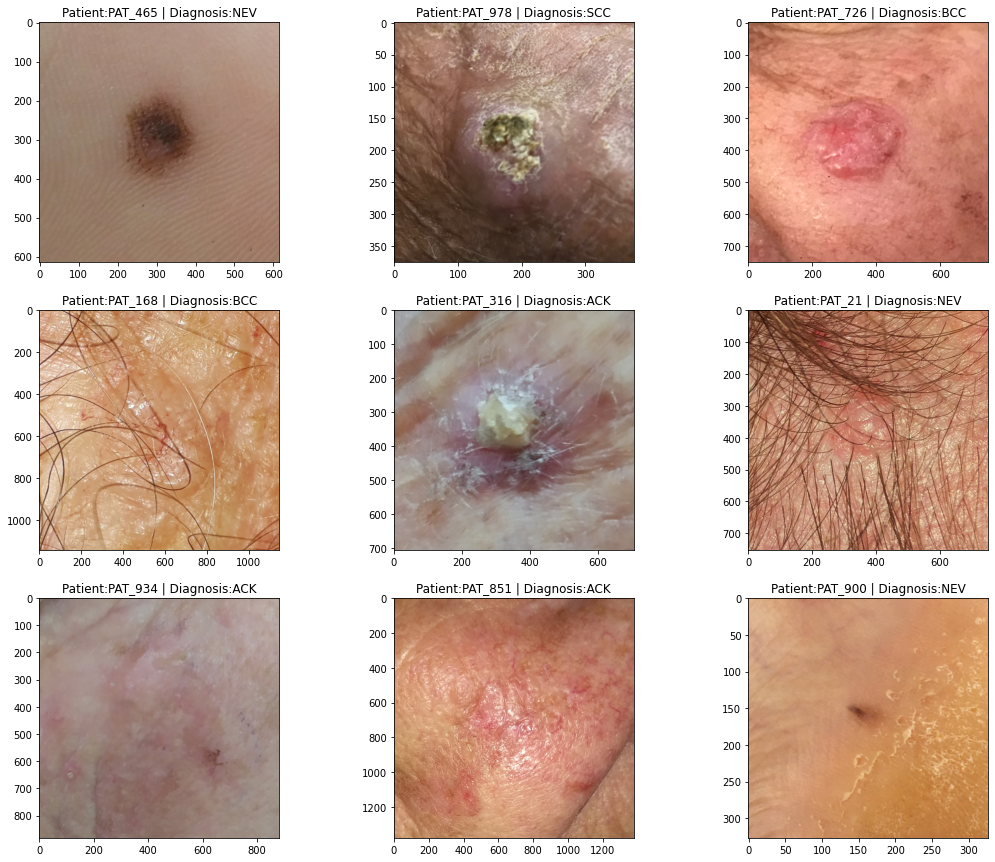

In [4]:
show_sample_pictures(df_filtered_not_null, random_seed=39);

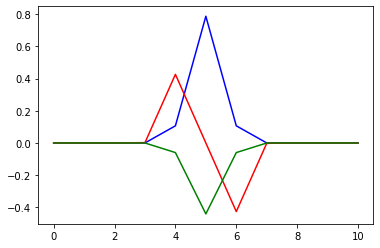

In [23]:
# https://stackoverflow.com/questions/35012080/how-to-apply-a-partial-derivative-gaussian-kernel-to-an-image-with-opencv
from random import gauss
from scipy import ndimage

kernel_size = 11
sigma = 0.5
kernel = cv2.getGaussianKernel(kernel_size, sigma, cv2.CV_64F)
# print(kernel)

gaussian_first_deriv_x = np.zeros_like(kernel)
assert(kernel_size % 2 == 1) # I assume you are using an odd kernel_size
half_kernel_size = int(kernel_size / 2)
for i in range(kernel_size):
    x = - half_kernel_size + i
    factor = - x/ (sigma**2)
    gaussian_first_deriv_x[i] = kernel[i] * factor

gaussian_second_deriv_x = ndimage.gaussian_filter1d(kernel, sigma=sigma, order=2, mode='wrap')

plt.plot(kernel[:], 'b')
plt.plot(gaussian_first_deriv_x[:], 'r')
plt.plot(gaussian_second_deriv_x[:], 'g')
plt.show()